[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)

#### based on Fig. S2 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [30]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolBoreal, AerosolMarine, AerosolNascent
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si, in_unit

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

import matplotlib
from matplotlib import pyplot

In [64]:
CI = 'CI' in os.environ
CI = True

nRes = 10
updraft_list = np.linspace(0.2, 2.4, 2 if CI else nRes)
models = ('Constant', 'CompressedFilmOvadnevaite')

FORMULAE = Formulae()
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w
aerosols = (
    AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolNascent(water_molar_volume=WATER_MOLAR_VOLUME)
)

consts = {"delta_min":0.1, 
          "MAC":1, 
          "HAC":1, 
          "c_pd":1006 * si.joule / si.kilogram / si.kelvin, 
          "g_std":9.81 * si.metre / si.second ** 2,
          "scipy_ode_solver":False
          }

In [65]:
def compute(key, settings):
    simulation = Simulation(settings)
    out = simulation.run()
    out['updraft'] = settings.w
    out['org_fraction'] = settings.aerosol.modes[0]['f_org']
    out['color'] = settings.aerosol.color
    return key, out

print(f'tasks scheduled: {len(models) * len(aerosols) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(f"w{w:.2f}_{aerosol.__class__.__name__}_{model}", Settings(
            dz = 10 * si.m if CI else 1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = aerosol,
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            **consts
        ))
        for w in updraft_list
        for model in models
        for aerosol in aerosols
    ))

tasks scheduled: 12
[0.2 2.4]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.0min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.1min remaining:   48.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.5min remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


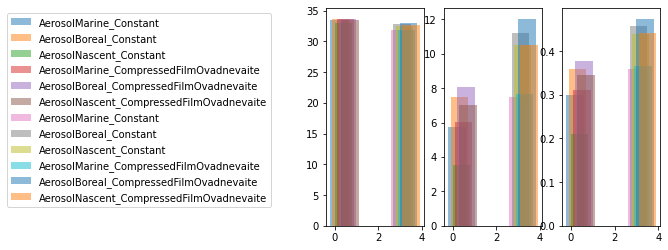

In [72]:
fig, axes = pyplot.subplots(1, 3)

optical_products = {}

for key, out_item in output.items():
    optical_products[key] = {}

    dz = np.diff(np.asarray(out_item['z']))
    rholwc = np.asarray(out_item['water mixing ratio']) * np.asarray(out_item['rhod'])
    optical_products[key]["lwp"] = np.sum(dz * (rholwc[:-1] + np.diff(rholwc)/2))

    cloud_top_index = -1
    optical_products[key]["reff"] = out_item['reff'][cloud_top_index]
    optical_products[key]["tau"] = (3 * optical_products[key]["lwp"]) / (2 * FORMULAE.constants.rho_w * optical_products[key]["reff"])
    g = 0.85 # asymmetry parameter
    optical_products[key]["albedo"] = ((1-g) * optical_products[key]["tau"]) / (2 + (1-g) * optical_products[key]["tau"])

    optical_products[key]["w"] = float(key.split("_")[0].split("w")[1])

for i,key in enumerate(output.keys()):
    ll = "_".join(key.split("_")[1:])
    ax = axes[0]
    ax.bar(optical_products[key]["w"]+i/10, in_unit(optical_products[key]["lwp"], si.g / si.m**2), alpha=0.5, label=ll)
    ax.legend(bbox_to_anchor=(-1, 0.5, 0.5, 0.5))

    ax = axes[1]
    ax.bar(optical_products[key]["w"]+i/10, optical_products[key]["tau"], alpha=0.5)

    ax = axes[2]
    ax.bar(optical_products[key]["w"]+i/10, optical_products[key]["albedo"], alpha=0.5)

pyplot.show()